# Running the Tabula Sapiens with a subset of the data with coexpr scoring.
                     
# INPUT: 

    * data/test_data/TabulaSapiens_subset.h5ad

# OUTPUT: 

    * data/test_data/coxpr_tabula-sub_results.pkl

# Environment Setup

In [1]:
work_dir = '../../' #Change to where git clone Cytocipher_manuscript/
import os
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

import utils.visualisation.helpers as vhs
import utils.visualisation.quick_plots as qpl
qpl.setUp()

import seaborn as sb
from matplotlib_venn import venn2

pre_dir = '/media/WorkingSpace/Share/hypo_atlas/'
data_dir = pre_dir+'data/test_data/'
out_dir = data_dir

import cytocipher as cc
import importlib as imp

import utils.preprocessing.load_data.simple_pickle as spl

# Loading the data

In [55]:
data = sc.read_h5ad(data_dir+'TabulaSapiens_subset.h5ad')

In [56]:
data.shape

(7385, 2435)

## Now let's run using Code-scoring to get p-values..

Also memory time elapsed & memory usage for bench-marking:
https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

In [57]:
import psutil

def get_process_memory():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

In [ ]:
##### Now re-running with the coexpr scoring...
#### TIME IT!!!
import time
import tracemalloc
start = time.time()
start_mem = get_process_memory()
tracemalloc.start()
cc.tl.merge_clusters(data, 'overclusters', var_groups='highly_variable', n_cpus=15, max_iter=0,
                     enrich_method='coexpr', 
                      k=None, squash_exception=True,
                     )
file_ = open(data_dir+'tabula-sub_coexpr-mem.txt', 'w')
print(tracemalloc.get_traced_memory(), file=file_)
tracemalloc.stop()
end = time.time()
end_mem = get_process_memory()

In [59]:
lapse = end-start
print("Time in seconds: ", lapse, file=file_)
lapse_mem = end_mem - start_mem
print("Memory used: ", lapse_mem, file=file_)

In [60]:
file_.close()

In [61]:
!cat {data_dir}tabula-sub_coexpr-mem.txt

(561287365, 620371932)
Time in seconds:  568.0157699584961
Memory used:  117497856


In [67]:
(620371932-561287365)/1e6

59.084567

In [68]:
568.0157699584961/60

9.466929499308268

In [69]:
##### Cacheing results from Coexpr-scoring
enrich = 'coexpr'
results = {'enrich': enrich}
results[f'overclusters_{enrich}_scores'] = data.obsm[f'overclusters_enrich_scores']
results[f'overclusters_merged_{enrich}_scores'] = data.obsm[f'overclusters_merged_enrich_scores']
results[f'overclusters_{enrich}_merged'] = data.obs['overclusters_merged']
uns_keys = [key for key in data.uns.keys() if key.startswith('overclusters_')]
for key in uns_keys:
    results[f'{key}_{enrich}'] = data.uns[key]

/home/s4392586/myPython/Cytocipher/cytocipher/plotting/cluster_diagnostics.py:110: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  score_data = sc.AnnData(cell_scores_df, obs=data.obs)
/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/plotting/_baseplot_class.py:122: UserWarning: Over 500 categories found. Plot would be very large.
  warn(


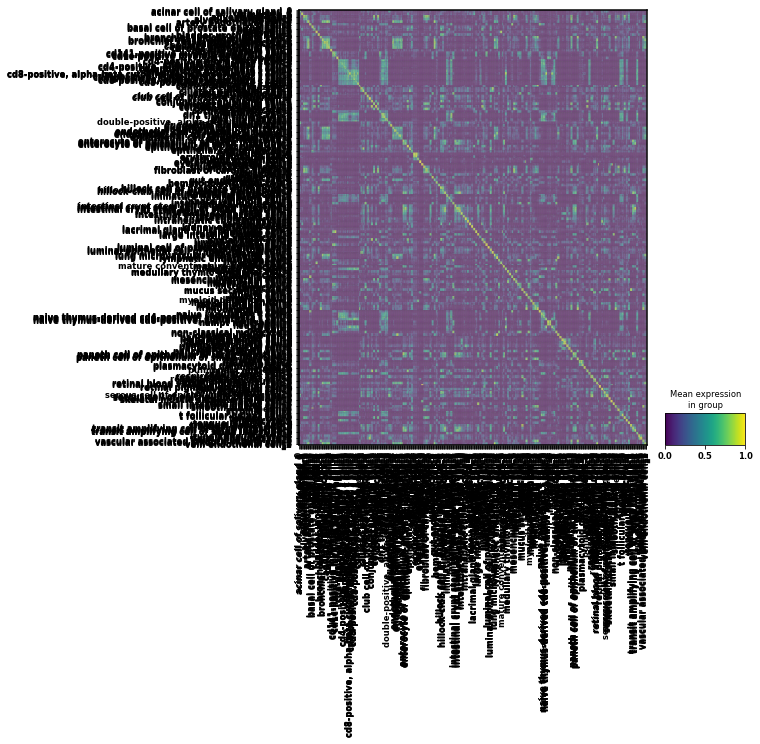

In [70]:
cc.pl.enrich_heatmap(data, 'overclusters', per_cell=False)

In [71]:
### Saving these results as a pickle object
spl.saveAsPickle(data_dir+f'{enrich}_tabula_results.pkl', results)